In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Hyperparameters
input_size = 784  # 28x28 images flattened
hidden_size = 128
output_size = 10   # Digits 0-9
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# MNIST Dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor()
)

# Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the Feedforward Neural Network
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten the images
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model, Loss, and Optimizer
model = FeedforwardNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Testing Loop
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.35MB/s]


Epoch [1/10], Loss: 0.3338
Epoch [2/10], Loss: 0.1488
Epoch [3/10], Loss: 0.1033
Epoch [4/10], Loss: 0.0782
Epoch [5/10], Loss: 0.0621
Epoch [6/10], Loss: 0.0497
Epoch [7/10], Loss: 0.0414
Epoch [8/10], Loss: 0.0331
Epoch [9/10], Loss: 0.0276
Epoch [10/10], Loss: 0.0228
Test Accuracy: 97.81%


Epoch 1 | Loss: 0.6226
Epoch 2 | Loss: 0.4820
Epoch 3 | Loss: 0.3928
Epoch 4 | Loss: 0.3303
Epoch 5 | Loss: 0.2911


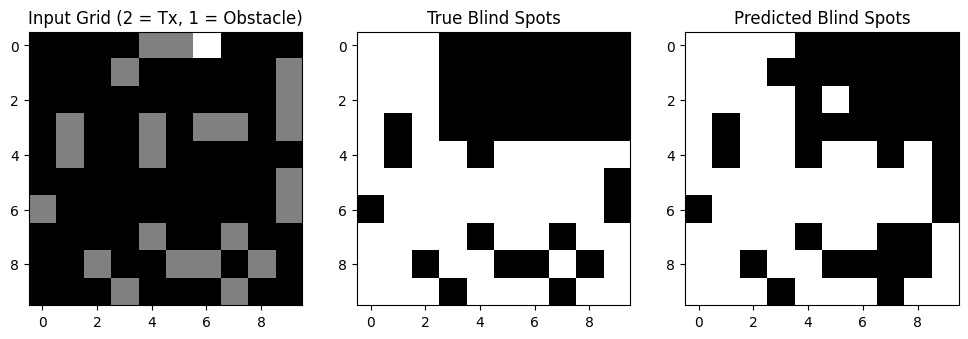

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Helper Functions
# ----------------------------

def create_grid(A, M, obstacle_prob=0.2):
    """Create a grid world with obstacles."""
    grid = np.random.choice([0, 1], size=(int(np.sqrt(M)), int(np.sqrt(M))), p=[1 - obstacle_prob, obstacle_prob])
    return grid

def coverage(grid, tx):
    """Simulate coverage of a transmitter tx in the grid."""
    cov = np.zeros_like(grid)
    for dx in range(-3, 4):
        for dy in range(-3, 4):
            x, y = tx[0] + dx, tx[1] + dy
            if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1] and grid[x, y] == 0:
                cov[x, y] = 1
    return cov

# ----------------------------
# 2. Dataset: BlindSpotDataset
# ----------------------------

class BlindSpotDataset(Dataset):
    def __init__(self, num_samples=1000, grid_size=10):
        self.samples = []
        for _ in range(num_samples):
            M = grid_size * grid_size
            grid = create_grid(A=0, M=M, obstacle_prob=0.2)
            free_cells = np.argwhere(grid == 0)
            tx = tuple(free_cells[np.random.choice(len(free_cells))])
            grid_with_tx = grid.copy()
            grid_with_tx[tx] = 2  # mark transmitter
            cov = coverage(grid, tx)
            blind_spot_map = ((grid == 0) & (cov == 0)).astype(float)
            self.samples.append((grid_with_tx, blind_spot_map))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        grid, blind_spots = self.samples[idx]
        x = torch.tensor(grid, dtype=torch.float32).unsqueeze(0)      # (1, N, N)
        y = torch.tensor(blind_spots, dtype=torch.float32).unsqueeze(0)
        return x, y

# ----------------------------
# 3. CNN Model Definition
# ----------------------------

class BlindSpotCNN(nn.Module):
    def __init__(self):
        super(BlindSpotCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.upconv1(x))
        x = torch.sigmoid(self.conv3(x))
        return x

# ----------------------------
# 4. Training Loop
# ----------------------------

# Hyperparameters
num_samples = 1000
grid_size = 10
batch_size = 16
learning_rate = 1e-3
num_epochs = 5

# Dataset and DataLoader
dataset = BlindSpotDataset(num_samples=num_samples, grid_size=grid_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = BlindSpotCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        preds = model(inputs)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1} | Loss: {total_loss / len(dataloader):.4f}")

# ----------------------------
# 5. Visualize Predictions
# ----------------------------

def visualize_blind_spots(dataset, idx):
    x, y = dataset[idx]
    with torch.no_grad():
        pred = model(x.unsqueeze(0)).squeeze().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x.squeeze(), cmap='gray')
    axs[0].set_title('Input Grid (2 = Tx, 1 = Obstacle)')
    axs[1].imshow(y.squeeze(), cmap='gray')
    axs[1].set_title('True Blind Spots')
    axs[2].imshow(pred > 0.5, cmap='gray')
    axs[2].set_title('Predicted Blind Spots')
    plt.show()

# Example Visualization
visualize_blind_spots(dataset, 0)

Epoch 1 | Loss: 0.6507
Epoch 2 | Loss: 0.5433
Epoch 3 | Loss: 0.4743
Epoch 4 | Loss: 0.4117
Epoch 5 | Loss: 0.3575
Test Loss: 0.3446


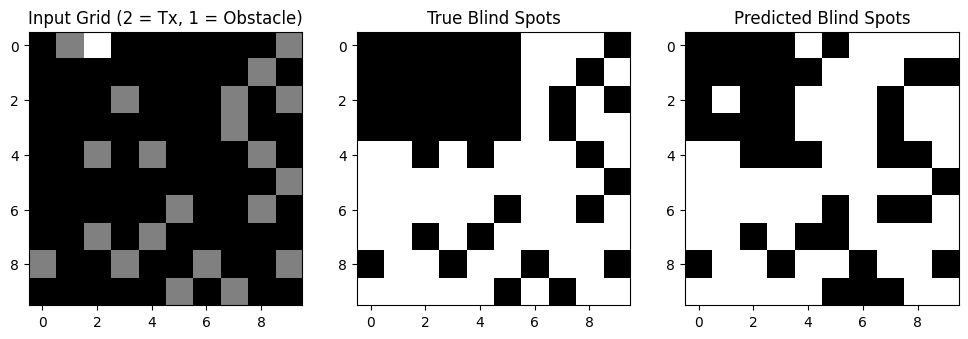

In [2]:
#final
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Helper Functions
# ----------------------------

def create_grid(A, M, obstacle_prob=0.2):
    """Create a grid world with obstacles."""
    grid = np.random.choice([0, 1], size=(int(np.sqrt(M)), int(np.sqrt(M))), p=[1 - obstacle_prob, obstacle_prob])
    return grid

def coverage(grid, tx):
    """Simulate coverage of a transmitter tx in the grid."""
    cov = np.zeros_like(grid)
    for dx in range(-3, 4):
        for dy in range(-3, 4):
            x, y = tx[0] + dx, tx[1] + dy
            if 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1] and grid[x, y] == 0:
                cov[x, y] = 1
    return cov

# ----------------------------
# 2. Dataset: BlindSpotDataset
# ----------------------------

class BlindSpotDataset(Dataset):
    def __init__(self, num_samples=1000, grid_size=10):
        self.samples = []
        for _ in range(num_samples):
            M = grid_size * grid_size
            grid = create_grid(A=0, M=M, obstacle_prob=0.2)
            free_cells = np.argwhere(grid == 0)
            tx = tuple(free_cells[np.random.choice(len(free_cells))])
            grid_with_tx = grid.copy()
            grid_with_tx[tx] = 2  # mark transmitter
            cov = coverage(grid, tx)
            blind_spot_map = ((grid == 0) & (cov == 0)).astype(float)
            self.samples.append((grid_with_tx, blind_spot_map))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        grid, blind_spots = self.samples[idx]
        x = torch.tensor(grid, dtype=torch.float32).unsqueeze(0)      # (1, N, N)
        y = torch.tensor(blind_spots, dtype=torch.float32).unsqueeze(0)
        return x, y

# ----------------------------
# 3. CNN Model Definition
# ----------------------------

class BlindSpotCNN(nn.Module):
    def __init__(self):
        super(BlindSpotCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.upconv1(x))
        x = torch.sigmoid(self.conv3(x))
        return x

# ----------------------------
# 4. Training Loop
# ----------------------------

# Hyperparameters
num_samples = 1000
grid_size = 10
batch_size = 16
learning_rate = 1e-3
num_epochs = 5

# Dataset and DataLoader
dataset = BlindSpotDataset(num_samples=num_samples, grid_size=grid_size)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = BlindSpotCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        preds = model(inputs)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1} | Loss: {total_loss / len(train_loader):.4f}")

# ----------------------------
# 5. Testing Loop
# ----------------------------

model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        preds = model(inputs)
        loss = criterion(preds, targets)
        test_loss += loss.item()
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# ----------------------------
# 6. Visualize Predictions
# ----------------------------

def visualize_blind_spots(dataset, idx):
    x, y = dataset[idx]
    with torch.no_grad():
        pred = model(x.unsqueeze(0)).squeeze().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x.squeeze(), cmap='gray')
    axs[0].set_title('Input Grid (2 = Tx, 1 = Obstacle)')
    axs[1].imshow(y.squeeze(), cmap='gray')
    axs[1].set_title('True Blind Spots')
    axs[2].imshow(pred > 0.5, cmap='gray')
    axs[2].set_title('Predicted Blind Spots')
    plt.show()

# Example Visualization
visualize_blind_spots(test_dataset, 0)